# Check out the Clay v1 model on the dataset

## Acknowledgements
Notebook adapted from https://clay-foundation.github.io/model/tutorials/clay-v1-wall-to-wall.html and https://github.com/Clay-foundation/model/blob/main/docs/tutorials/clay-v1-wall-to-wall.ipynb

In [1]:
import math

import geopandas as gpd
import numpy as np
import pandas as pd
import pystac_client
import pyproj
import stackstac
import torch
import yaml
from box import Box
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from shapely import Point
from torchvision.transforms import v2
from einops import rearrange

import shapely
import json

from src.models.clay.model import ClayMAEModule

from src.data.get_satellite_images import ReadSTAC

In [2]:
api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
# bands from B01 to B12
# bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
bands = ['B02', 'B03', 'B04', 'B08']

stac_reader = ReadSTAC(api_url=api_url)

# Load Dataset

In [3]:
# load the processed dataset
tiles = gpd.read_file("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg", layer="tiles")
masks = gpd.read_file("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg", layer="masks")
bounding_boxes = gpd.read_file("data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg", layer="bounding_boxes")

In [4]:
# select first row
row = tiles.iloc[0]
row

tile_id                                                         621
sentinel_2_id     S2B_MSIL2A_20190517T144739_R139_T20NMP_2020100...
source_dataset                                                 tang
timestamp                                2024-06-19 09:07:50.341000
geometry          POLYGON ((-63.33333333333334 7.333333333333343...
Name: 0, dtype: object

In [5]:
# convert geojson string to shapely geometry
bounds = row.geometry.bounds
bounds

(-63.5, 7.333333333333343, -63.33333333333334, 7.5)

In [6]:
# get lat and lon
lat = row.geometry.centroid.y
lon = row.geometry.centroid.x

In [7]:
# add a square bounding box with length of 20.48km around the centroid
def add_square_bbox(row, crs, buffer=20480):
    # get tranformer to project from WGS84 to UTM
    transformer = pyproj.Proj(crs)

    # get centroid
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y

    # 
    x_utm, y_utm = transformer(x, y)
    bbox = [y_utm+buffer, y_utm-buffer, x_utm-buffer, x_utm+buffer]

    # convert back to latlon
    bbox = 
    return bbox

tiles["bbox"] = tiles.apply(add_square_bbox, crs=tiles.crs, axis=1)

SyntaxError: invalid syntax (2287184495.py, line 15)

In [7]:
from shapely.ops import transform
import shapely
from tqdm import tqdm
import pyproj
from functools import partial

def add_bbox(row): 
    point = row.geometry.centroid

    # Define the projection to UTM (Universal Transverse Mercator)
    # Find UTM zone for the centroid of the polygon for more accuracy
    utm_zone = int((point.x + 180) / 6) + 1
    crs_proj = pyproj.Proj(proj='utm', zone=utm_zone, ellps='WGS84', preserve_units=False)

    # Define transformations from WGS84 to UTM and back
    project_to_utm = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'), crs_proj)
    project_to_wgs84 = partial(pyproj.transform, crs_proj, pyproj.Proj(init='epsg:4326'))

    # Transform the polygon to the UTM projection
    point = transform(project_to_utm, point)

    # calculate the bbox using the buffer
    buffer = 5000
    bbox = (point.x - buffer, point.y - buffer, point.x + buffer, point.y + buffer)

    # convert bbox to polygon
    bbox = shapely.geometry.box(*bbox)

    # Transform the polygon back to WGS84
    bbox = transform(project_to_wgs84, bbox)

    return bbox

tiles["bbox"] = tiles.apply(add_bbox, axis=1)

In [22]:
type(tiles)

geopandas.geodataframe.GeoDataFrame

# Load Items and stack for the first row

In [12]:
# get the item 
item = stac_reader.get_item_by_name(row.sentinel_2_id)

# read as stack
stack = stac_reader.get_stack(
    items=item, 
    bands=bands,
    crop_to_bounds=False, 
    squeeze_time_dim=False,
    custom_point_and_buffer=[lon, lat, 10240],
    )
stack

Loading stack...
Returning stack from single S2 image with ID: S2B_MSIL2A_20190517T144739_R139_T20NMP_20201006T152830


<xarray.DataArray 'stackstac-7eb920bfa51ed018fc494b2295a16da3' (time: 1,
                                                                band: 4,
                                                                y: 2048, x: 2048)> Size: 67MB
dask.array<getitem, shape=(1, 4, 2048, 2048), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/47)
  * time                                     (time) datetime64[ns] 8B 2019-05...
    id                                       (time) <U54 216B 'S2B_MSIL2A_201...
  * band                                     (band) <U3 48B 'B02' ... 'B08'
  * x                                        (x) float64 16kB 4.438e+05 ... 4...
  * y                                        (y) float64 16kB 8.301e+05 ... 8...
    s2:generation_time                       <U24 96B '2020-10-06T15:28:30.551Z'
    ...                                       ...
    proj:bbox                                object 8B {399960.0, 790200.0, 5...
    common_name                              (band) <U5 80B 'blue' ... 'nir'
    center_wavelength                        (band) float64 32B 0.49 ... 0.842
    full_width_half_max                      (band) float64 32B 0.098 ... 0.145
    epsg                                     int64 8B 32620
    s2_tile_id                               <U54 216B 'S2B_MSIL2A_20190517T1...
Attributes:
    spec:        RasterSpec(epsg=32620, bounds=(399960, 790200, 509760, 90000...
    crs:         epsg:32620
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 900000.00|\n| 0.00...
    resolution:  10
    s2_tile_id:  S2B_MSIL2A_20190517T144739_R139_T20NMP_20201006T152830

### Load the model

We now have the data to analyse, let's load the model.

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt"
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

### Prepare band metadata for passing it to the model

This is the most technical part so far. We will take the information in the stack of imagery and convert it into the formate that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

The Clay model will accept any band combination in any order, from different platforms. But for this the model needs to know the wavelength of each band that is passed to it, and normalization parameters for each band as well. It will use that to normalize the data and to interpret each band based on its central wavelength.

For Sentinel-2 we can use medata file of the model to extract those values. But this cloud also be something custom for a different platform.

In [15]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open("configs/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

### Convert the band pixel data in to the format for the model

We will take the information in the stack of imagery and convert it into the formate that the model requires. This includes converting the lat/lon and the date of the imagery into normalized values.

In [16]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = [stack["s2:generation_time"].values.astype("datetime64[s]").tolist()]
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32).compute())
pixels = transform(pixels)

### Combine the metadata and the transformed pixels

Now we can combine all of these inputs into a dictionary that combines everything.

In [17]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(stack.gsd.values, device=device),
    "waves": torch.tensor(waves, device=device),
}

### Run the model

Pass the datacube we prepared to the model to create embeddings. This will create one embedding vector for each of the images we downloaded.

In [18]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()
embeddings.shape

RuntimeError: [enforce fail at alloc_cpu.cpp:83] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 206164721712 bytes. Error code 12 (Cannot allocate memory)

### Visualize the original image

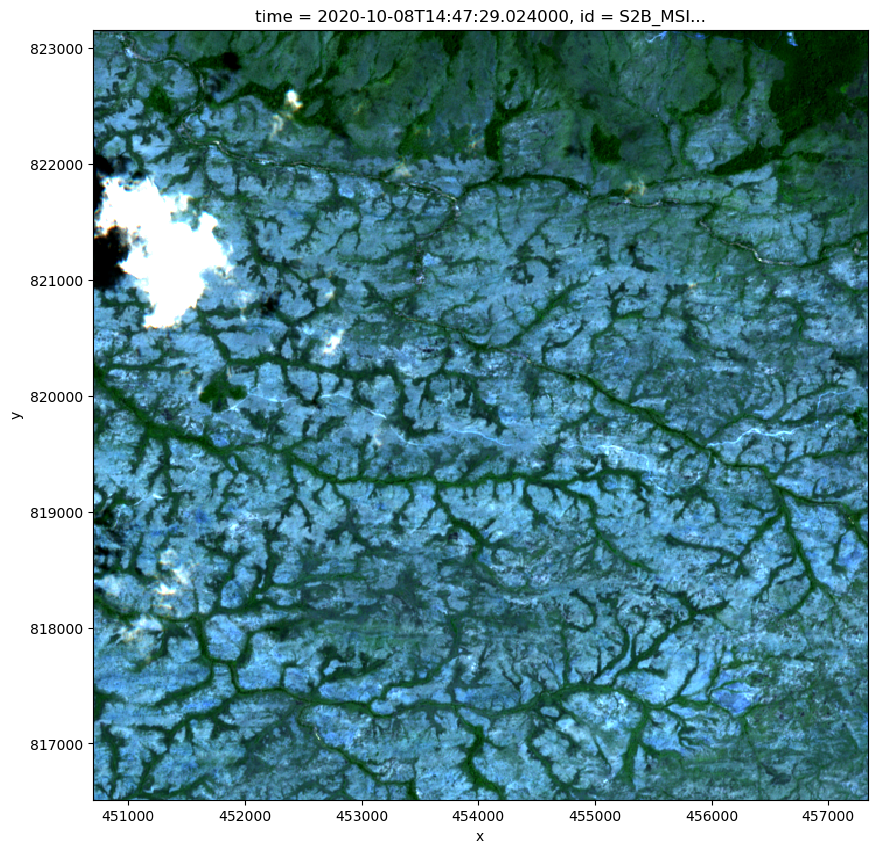

In [ ]:
# visualize the image
image_stack = stack[0, :3, :, :]
image_stack.plot.imshow(robust=True, figsize=(10, 10))

### Explore the embeddings
ClayMAE model is trained using patch_size of 8. For chip_size of 664 x 664, we have

664 // 8 -> 83 rows
664 // 8 -> 83 cols

83 * 83 -> 6889 patches are passed through the forward pass of the model.

Here we see unmsk_patch shapes of size batch x (1 + 6889) x 768, i.e
1 -> cls_token
6889 -> patches
768 -> embedding dim

In [ ]:
print(unmsk_patch.shape)
embeddings.shape

torch.Size([1, 6890, 768])


(1, 768)

Rearrange the embeddings from the Clay Encoder back to images.

Embeddings are of shape: ``batch x (1:cls_token + 784:patches) x 768:embedding dimension``

``784:patches`` can be transformed into images of shape ``28 x 28``

``768:embedding`` dimension can be moved as channel dimension

Here, each embedding dims represents a particular unique feature of the chip

In [ ]:
unmsk_embed = rearrange(
    unmsk_patch[:, 1:, :].detach().cpu().numpy(), "b (h w) d-> b d h w", h=83, w=83
)

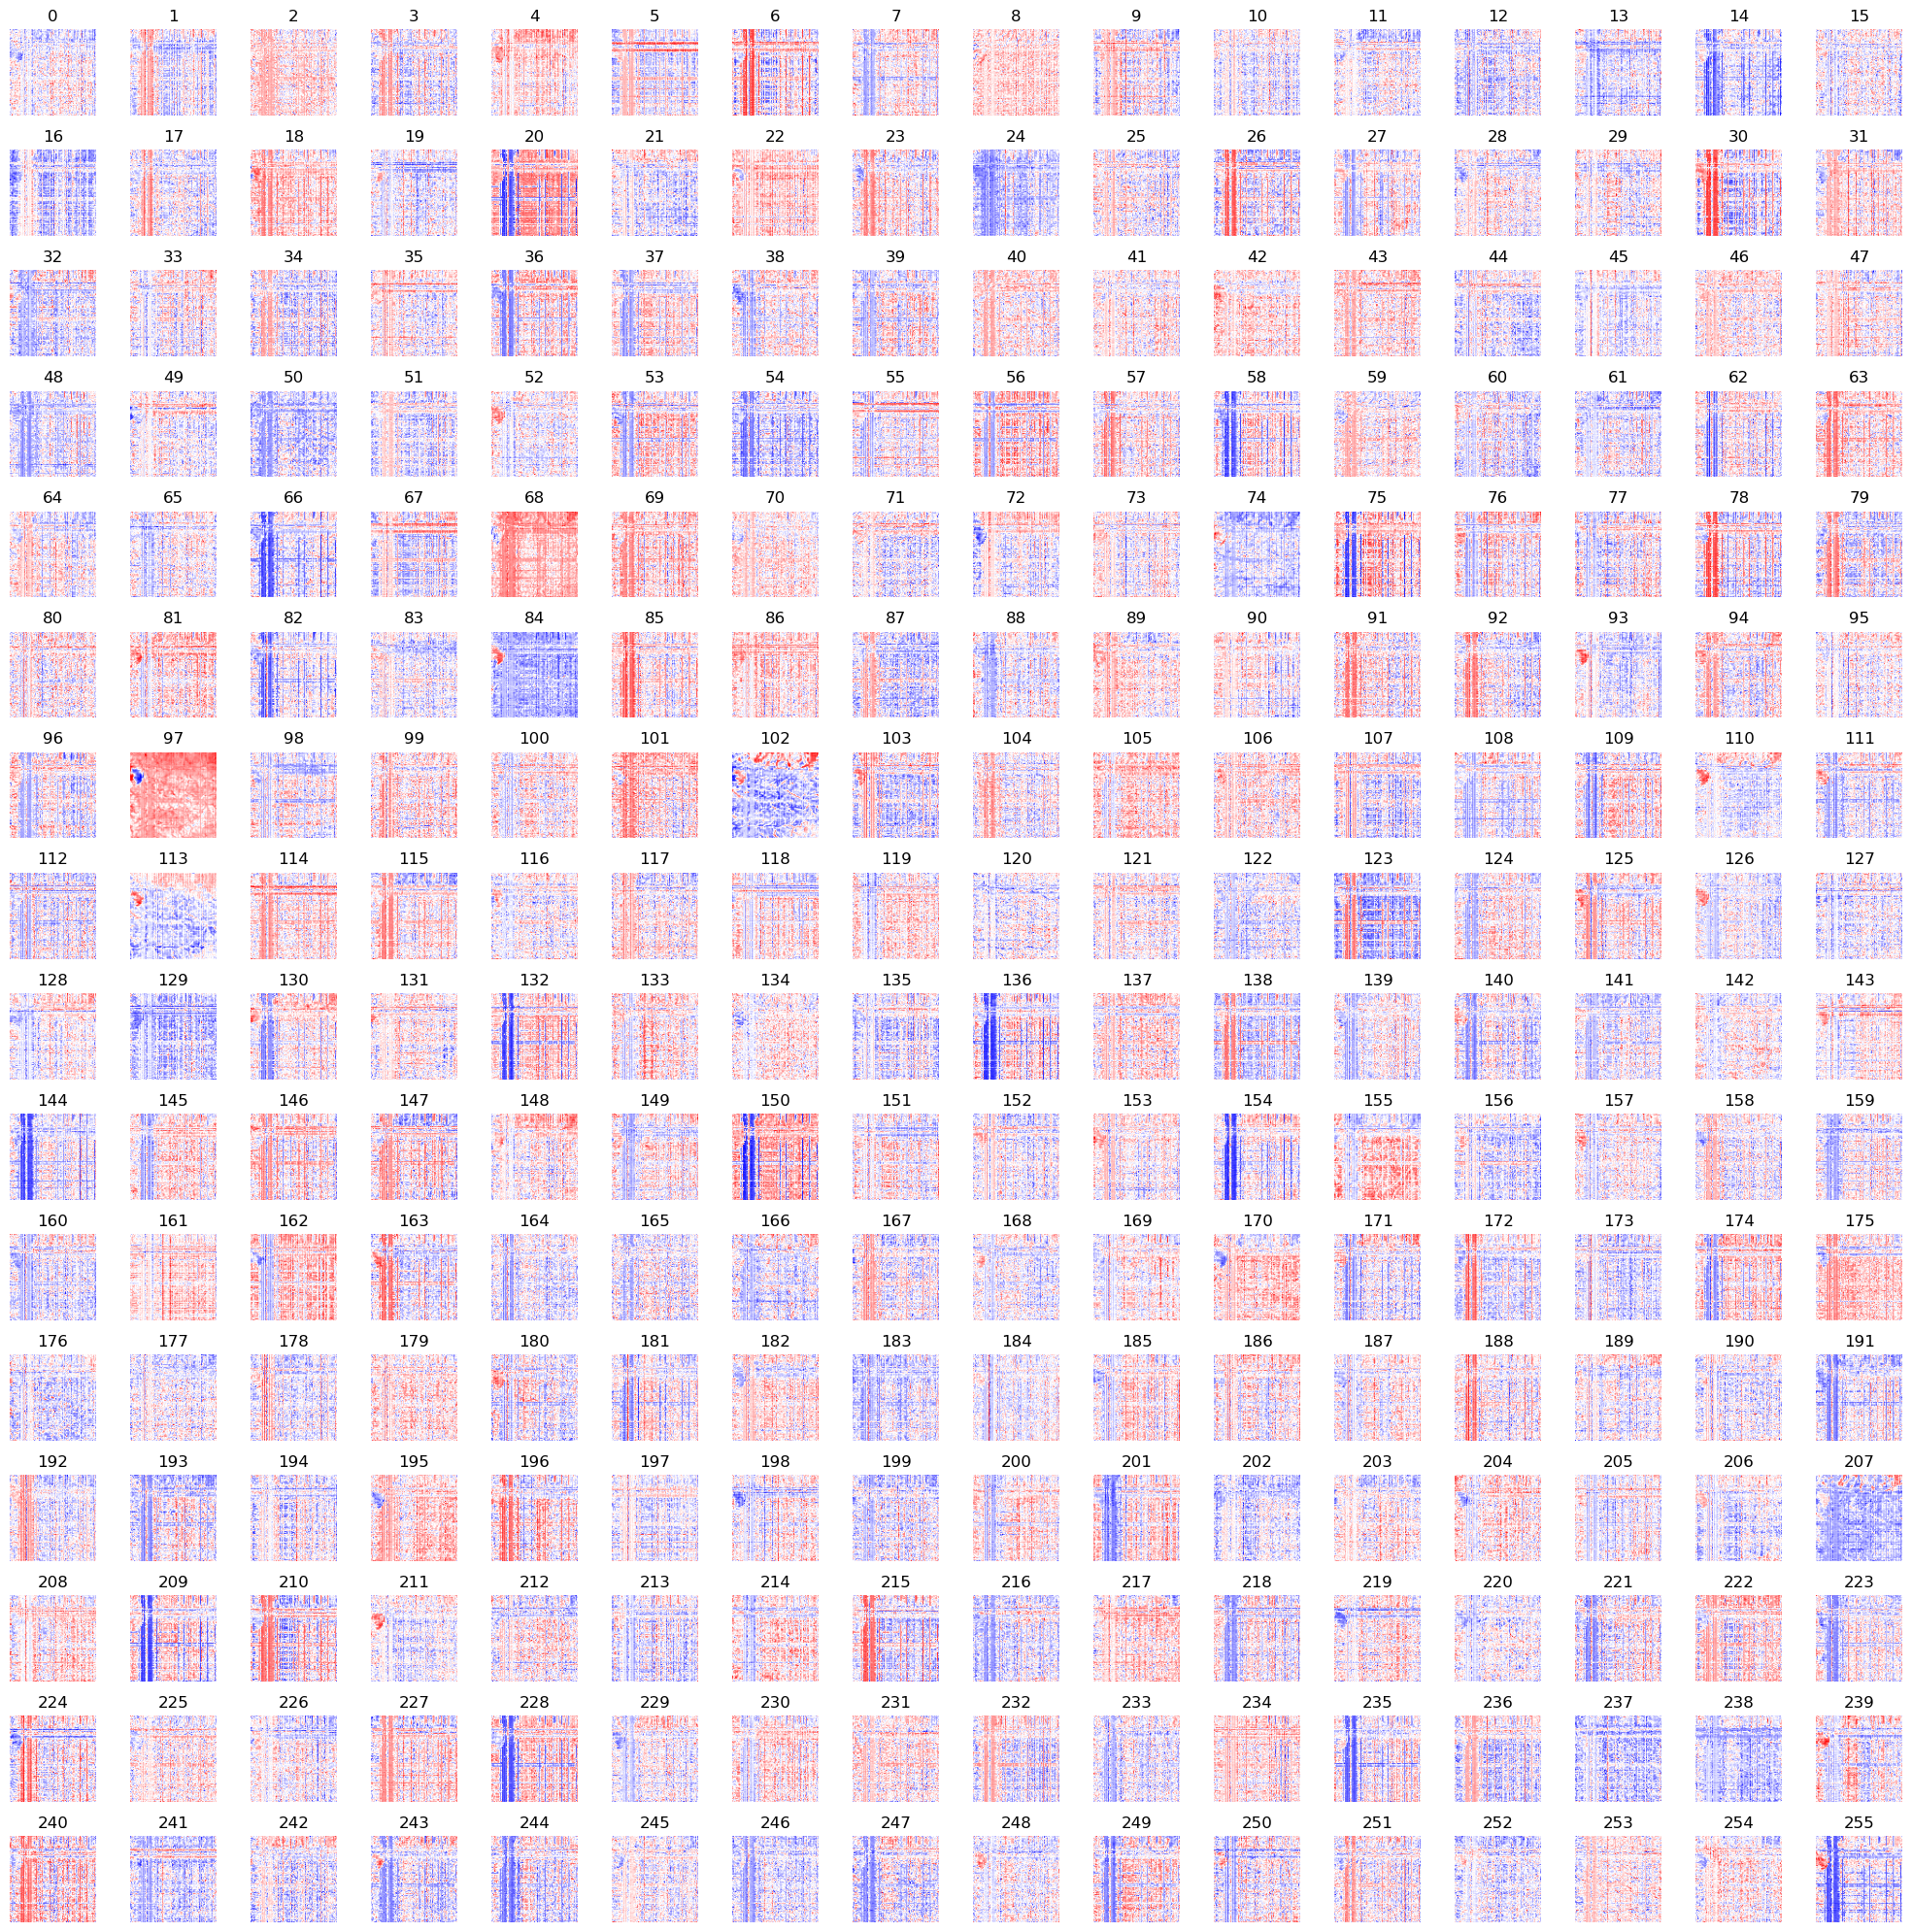

In [ ]:
# choose only the first image (there is only one anyway)
embed = unmsk_embed[0] 

fig, axs = plt.subplots(16, 16, figsize=(20, 20))

for idx, ax in enumerate(axs.flatten()):
    ax.imshow(embed[idx], cmap="bwr")
    ax.set_axis_off()
    ax.set_title(idx)
plt.tight_layout()

# Test a small decoder to locate the mine bbox

In [ ]:
# TODO